# Exercise 05 - Denoising (25 + 45 = 70 (+ 10))
In the lecture you have learned that noise is inevitable in digital imaging. In the last exercise sheet you
were asked to reduce noise in an image by averaging multiple shots of the same scene. However, averaging
multiple images of moving objects/dynamic scenes under dim lighting conditions (think of a live concert,
for example) is a delicate task. Also increasing the exposure time to gather more light is often not an option
due to motion blur. As a result, there is only a very faint signal forming the image on the sensor.
Using typical CCD or CMOS sensors, this signal can not be amplified without also amplifying noise.
Hence, denoising is an important image processing task.  

There is a big variety of algorithms that reduce noise from images in a post processing step. In this
exercise you will first implement a measure to determine the Signal-to-Noise Ratio (SNR) in an image, given
the noise-free ground truth image. You will also implement a very easy, yet effective filter to remove noise
from an image, namely the so-called _Bilateral Filter_.  
A more powerful approach is the _Non-Local Means Filter_. In the second part of the exercise you will be guided through a simple implementation of this filter.

## Examples
Run the following cells to see a visualization of a ground truth and noisy image pair.  
The noisy image is generated by adding gaussian noise. Feel free to try any other of the ground truth images for testing later.

In [1]:
%matplotlib widget
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm

from noise import add_gaussian_noise

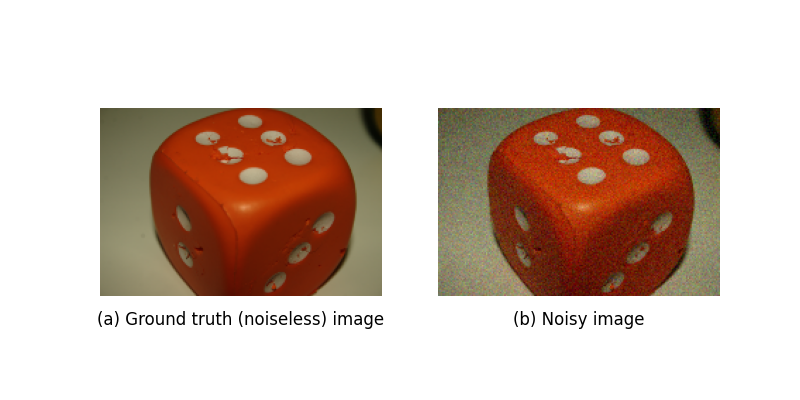

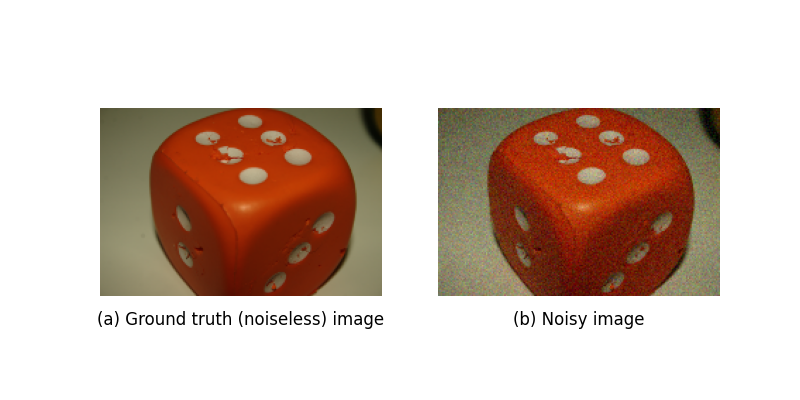

In [46]:
# Load the ground truth image.
ground_truth_image = imageio.imread(os.path.join("images", "dice.png"))
# Other images for testing.
# ground_truth_image = imageio.imread(os.path.join("images", "tablet.tiff"))
# ground_truth_image = imageio.imread(os.path.join("images", "tablet_small.tiff"))
# ground_truth_image = imageio.imread(os.path.join("images", "flowers.png"))
# ground_truth_image = imageio.imread(os.path.join("images", "man.png"))

ground_truth_image = ground_truth_image.astype(np.float32) / 255.0

# Add noise to the image.
noisy_image = add_gaussian_noise(
    ground_truth_image, mean=0, sigma=0.05, color=True
)


fig, axs = plt.subplots(1, 2, figsize=[8, 4])
axs[0].imshow((ground_truth_image * 255).astype(np.uint8))
axs[0].set_title("(a) Ground truth (noiseless) image", y=-0.2)
axs[1].imshow((noisy_image * 255).astype(np.uint8))
axs[1].set_title("(b) Noisy image", y=-0.2)

for j in range(2):
    axs[j].set_axis_off()
fig.set
fig.show()

## 1. Simple Image Denoising
### a) (2)
As you heard in the lecture we can measure the noise in a signal using Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) which is based on the MSE.  
Compute both using the scikit implementation on the already loaded __ground_truth_image__ and __noisy_image__. (HINT: Scikit-image comes installed with your pipenv environment.)

In [47]:
# Todo import and call functions from scikit-image.
# Found at https://scikit-image.org/docs/stable/api/skimage.metrics.html#module-skimage.metrics
import skimage

mse_noisy_scikit = skimage.metrics.mean_squared_error(ground_truth_image, noisy_image)
psnr_noisy_scikit = skimage.metrics.peak_signal_noise_ratio(ground_truth_image, noisy_image)
print("MSE scikit-image implementation: {}".format(mse_noisy_scikit))
print("PSNR scikit-image implementation: {}".format(psnr_noisy_scikit))



MSE scikit-image implementation: 0.002303447096125747
PSNR scikit-image implementation: 26.37621757852154


### b) (6)
The best (and probably only) way to reduce variance of a measurement is to average over multiple samples. This works best if you have some time and the subject does not move. Let's try it.

When executing the next cell you will load some images into an array images of shape [N, H, W, C] and some dark frames for the camera which are stored in an array dark_frames of shape [N, H, W, C] where N is the number of images, H, W the spatial dimensions and C the color channels.

Calculate the average dark frame, the average image and use the obtained dark frame to improve the quality of the averaged image.

In [48]:
# Loading images from files
dark_frames = []
images = []
dark_path = os.path.join("images", "dark", "{}.tiff")
imgs_path = os.path.join("images", "imgs", "{}.tiff")
for i in range(1, 17):
    images.append(imageio.imread(imgs_path.format(i)).astype(np.float32) / 255)
    dark_frames.append(imageio.imread(dark_path.format(i)).astype(np.float32) / 255)
images = np.stack(images)
dark_frames = np.stack(dark_frames)

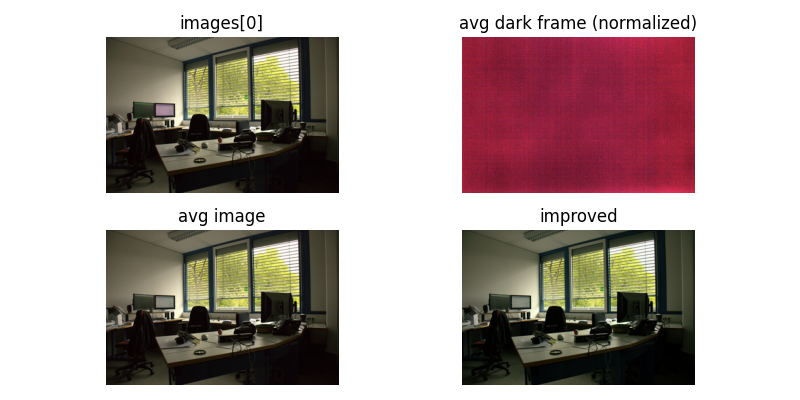

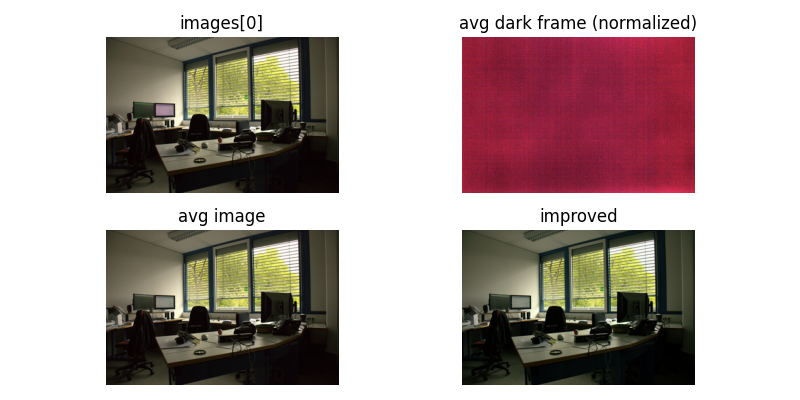

In [49]:
avg_dark_frame = np.mean(dark_frames, axis=0)  # TODO
avg_image = np.mean(images, axis=0)       # TODO
improved_img = avg_image - avg_dark_frame   # TODO

# showing result
fig, axs = plt.subplots(2, 2, figsize=[8, 4], sharex="all", sharey="all")
for ax in axs:
    for a in ax:
        a.set_axis_off()
axs[0][0].imshow(images[0])
axs[0][0].set_title("images[0]")
axs[0][1].imshow(avg_dark_frame/np.max(avg_dark_frame))
axs[0][1].set_title("avg dark frame (normalized)")
axs[1][0].imshow(avg_image)
axs[1][0].set_title("avg image")
axs[1][1].imshow(np.clip(improved_img, 0, 1))
axs[1][1].set_title("improved")
fig.tight_layout()
fig.show()

### c) (2)
Use a simple Gauss filter to remove noise from the noisy image and compare the PSNR value of
the result with the PSNR value of the input image. You are allowed to use the filter operations that come with either _opencv_ or _scikit-image_ this time.  

HINT: Display the filtered image to verify your results visually.

PSNR gauss filter: 32.30996441529683
PSNR improvement: 5.933746836775292


/tmp/ipykernel_5214/3156774948.py:3: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  gaussian_filtered_image = skimage.filters.gaussian(noisy_image, sigma=1, mode='nearest', cval=0, preserve_range=False, truncate=4.0)


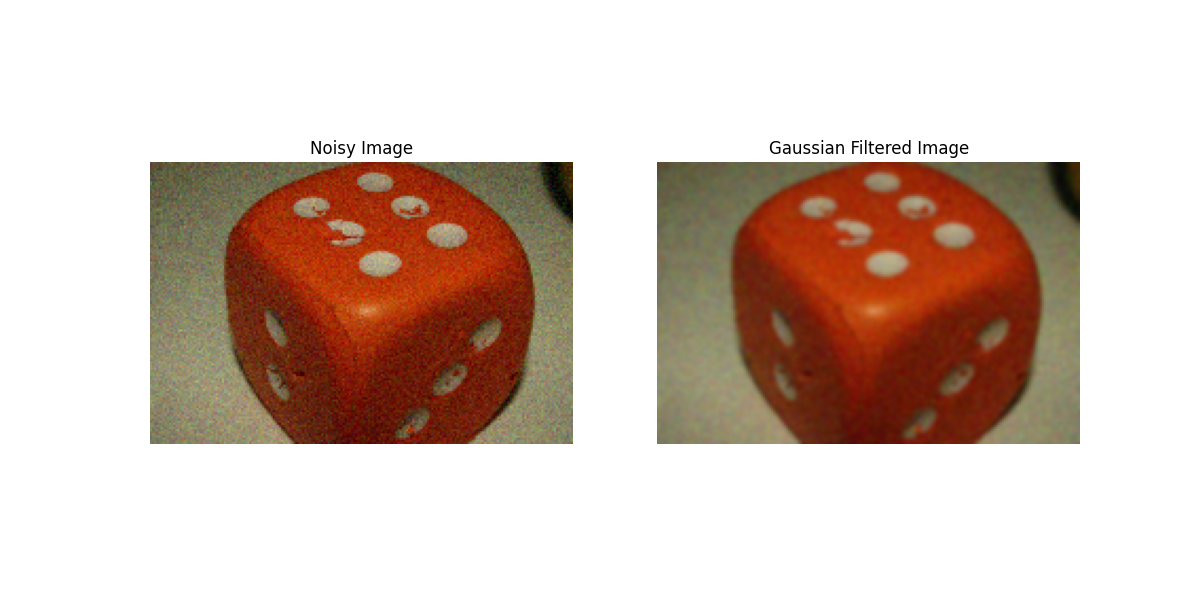

In [51]:
gauss_sigma = 1
# Todo: Apply a gaussian filter to the image.
gaussian_filtered_image = skimage.filters.gaussian(noisy_image, sigma=1, mode='nearest', cval=0, preserve_range=False, truncate=4.0)

# Todo: Compute the PSNR here.
psnr_gauss = skimage.metrics.peak_signal_noise_ratio(ground_truth_image, gaussian_filtered_image)
print("PSNR gauss filter: {}".format(psnr_gauss))
print("PSNR improvement: {}".format(psnr_gauss - psnr_noisy_scikit))



fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(noisy_image, cmap='gray')
axes[0].set_title('Noisy Image')
axes[0].axis('off')

axes[1].imshow(gaussian_filtered_image, cmap='gray')
axes[1].set_title('Gaussian Filtered Image')
axes[1].axis('off')

plt.show()

### d) (15)
Implement a function `bilateral_filter(img, sigma_s, sigma_r)` where __img__ is the noisy input image, __sigma_s__ the standard deviation for the spatial domain filter and __sigma_r__ is the standard deviation in the color domain.  
Compare the result and PSNR with the result of the Gauss filter.

HINT: You might want to use a progress bar to show the progress of the filter operation. You can use _tqdm_. You can implement your own Gaussian filter or use OpenCV, for example.

In [ ]:
def bilateral_filter(img: np.ndarray, sigma_s: float, sigma_r: float) -> np.ndarray:
    """Todo
    
        Bilateral filter with sigma_s for the spatial gauss filtering and sigma_r
        for the gauss filter in color space.
        
    Args:
        img:
            Input image to be filtered.
        sigma_s:
            Standard deviation for the kernel in the spatial domain.
        sigma_r:
            Standard deviation for the kernel in the color domain.
    
    Returns:
        The filtered image as np array.
    """
    
    img_shape = img.shape
    
    # Initialize output.
    out_img = np.zeros_like(img)
            
    return out_img
    

In [ ]:
# Apply the bilateral filter and compare the PSNR.
sigma_s = 2
sigma_r = 0.15

# Call your bilateral filter here.
bilateral_filtered_image = bilateral_filter(noisy_image, sigma_s, sigma_r)
# Todo: Compute the psnr here.
psnr_bilateral = 0

print("PSNR bilateral filter: {}".format(psnr_bilateral))
print("PSNR improvement: {}".format(psnr_bilateral - psnr_noisy_scikit))



## 2. Non-Local Means Filter
With the Bilateral Filter you have implemented your first non-trivial filter for image denoising. In this
exercise you will create a simple implementation of a more advanced denoising filter: The Non-Local
Means Filter (NLM filter). We use the same functions as in Exercise 1 to compare the results of the
NLM filter. The NLM filter can be vectorized and thus be implemented efficiently using numpy, however,
the vectorization is rather complicated and obscures the individual steps of the algorithm. In contrast,
our step-by-step implementation will operate pixel-wise and therefore be slow. You might want to load
the small __ground_truth_image__ (tablet_small.tiff) above for debugging purposes.  

Mathematically, the NLM filter can be formulated as:  
$$
\begin{align}
\hat{x}(i) = \frac{1}{C(i)}\int_{\Omega(i)}v(i)\,w(i,j) \, dj\qquad
    \text{with} \qquad
    C(i) = \int_{\Omega(i)}w(i,j) \, dj
\end{align}
$$
where $i$ is a pixel position, $\hat{x}(i)$ the filter output color intensity at that position, $v(i)$ the unfiltered pixel value at position $i$, $w(i,j)$ a weighting function and $\Omega(i)$ an area around pixel $i$, which is a subset of the entire image. Consequently, the filter output is a weighted average (mean) over the image patch $\Omega(i)$. The weighting function $w(i,j)$ computes the similarity between the pixel $i$ and $j$. The similarity is computed by comparing
a small patch around $i$ with a small patch around $j$.

### a) (15)
A crucial component of the NLM filter is the comparison of image patches.
The similarity $w(i,j)$ between two image patches $P_i$ and $P_j$ centered respectively at $i$ and $j$ is defined as  
        $$w(i,j)=e^{-\frac{\|P_i - P_j\|^2}{2\sigma^2}}$$. 

Implement a function `similarity_weight(patch1, patch2, sigma)` ($i$ would correspond to 1 and $j$ to 2 here) which returns the similarity between two given patches in this manner.

In [ ]:
"""Todo"""


### b) (5 + 5 + 15 + 5)
Now complete the `non_local_means_filter` function which takes the __search_r__, __similarity_r__ and, again, __sigma__ as input and output the filtered image.  
1. The NLM filter considers small square-shaped patches around pixels to compute similarities between pixels. Extend the input image in such a way that even pixels on the border can be compared. (HINT: The radius of the patch is given by __similarity_r__.)
2. For a pixel at position $p = (y, x)$ extract the patch for the similarity comparison with all other pixels in the search radius.
3. Iterate over the pixels in the search radius around $p = (y, x)$ and compute the similarity of those pixels using the function from a). The pixel at position $p = (y, x)$ is also contained in this search window - however, it gets a special treatment. Instead of reporting the similarity 1 on that pixel we use the maximum similarity amongst all other pixels in the window to weight it. Use the similarity as a weight to compute the average pixel value and sum up all used weights.
4. Compute the filtered pixel value and write it to the result image. It can happen that the similarity of all pixels in the search window was zero (horrible image or wrong parameters). In that case just copy the input pixel to the result. Otherwise, normalize the computed pixel average using the summed weights according to the formula above.

In [ ]:
def non_local_means_filter(img: np.ndarray, search_r: int, similarity_r: int, sigma: float) -> np.ndarray:
    """Denoise the input using the Non Local Means algorithm.

    Args:
        img:
            Noisy input image to be denoised.
        search_r:
            Defines the radius around each pixel to seach for similar
            pixels. In theory this would be the entire image,
            but for performance reasons we limit the search to a window.
        similarity_r:
            Radius of a patch around a pixel that is used to determine
            the similarity to other pixels (patches are compared).
        sigma:
            Standard deviation for determining the similarity between
            patches (used in SimilarityWeight).

    Returns:
        Denoised image as np array.
    """
    # Allocate output.
    out_img = np.zeros_like(img)

    # 1. Pad the input image to enable similarity comparison patches at the borders.
    # Todo


    # Start of the main loop. Using a progress bar, again.
    for y in tqdm(range(img.shape[0]), desc="NLM filtering"):
        for x in range(img.shape[1]):
            # 2. Extract patch around the pixel (y, x) for comparison.
            # This window is then used to calculate the similarity to all
            # other pixels in the search radius around this pixel.

            # Todo!

            # 3. Iterate over all pixels in the search window. Be careful not to cross
            # image boundaries.
            # * Skip the loop if the current pixel is at position (y,x).
            # * Else extract a similarity window around the pixel.
            # * Use the similarity_weight function from a) to compute the weight of the pixel.
            # * Add the weighted pixel value to the average pixel value (pixel_average)
            #   and the weight to the total pixel weight (pixel_weight)
            # * Keep track of the maximum weight that was found and use it to
            #   weight the pixel (y, x) in the end (after the iteration).

            pixel_average = np.zeros([1, 1, 3])
            pixel_weight = 0
            max_weight = 0
            
            # Todo...
            
            
            # 4. Write the result into the output image.
            
            # Todo!

    return out_img

In [ ]:
# Apply the NLM filter and compare the PSNR.
search_window_r = 10
similarity_window_r = 3
sigma = 0.1

# Call your NLM implementation here.
nlm_filtered_image = non_local_means_filter(noisy_image, search_window_r, similarity_window_r, sigma)
# Todo: Compute PSNR here.
psnr_nlm = 0

print("PSNR NLM filter: {}".format(psnr_nlm))
print("PSNR improvement: {}".format(psnr_nlm - psnr_noisy_scikit))

# You might also want to check your output image.

### c) (10) (Bonus)
Compare the results to the methods from the first part of the exercise sheet.  
Try to find good parameters for all three methods (Gauss, Bilateral, NLM) on one of the given images (in images folder - you can just uncomment any of the lines in the second cell of this notebook). Create images that show results for 3 different parameter settings and explain the impact of the parameters (in text). Also compare the PSNR values. Do they represent your visual impression of the reconstruction quality?  

HINT: Don’t rise the search and similarity window radii too much. Try figuring out the best $\sigma$ values.

Run the following cell to get an overview plot of all the denoising approaches.

In [ ]:
# Plot all results for comparison.
# Also show difference images.

grey = np.ones_like(noisy_image) * 0.5

fig2, axs2 = plt.subplots(3, 3, figsize=[10, 8])
axs2[0][0].imshow(ground_truth_image)
axs2[0][0].set_title("Ground truth", y=-0.2)
axs2[0][1].imshow(noisy_image)
axs2[0][1].set_title("Noisy image (PSNR {:2.3f})".format(psnr_noisy_own), y=-0.2)
axs2[0][2].imshow(grey + noisy_image - ground_truth_image)
axs2[0][2].set_title("Only noise", y=-0.2)

axs2[1][0].imshow(gaussian_filtered_image)
axs2[1][0].set_title("Gauss filter (PSNR {:2.3f})".format(psnr_gauss), y=-0.2)
axs2[1][1].imshow(bilateral_filtered_image)
axs2[1][1].set_title("Bilateral filter (PSNR {:2.3f})".format(psnr_bilateral), y=-0.2)
axs2[1][2].imshow(nlm_filtered_image)
axs2[1][2].set_title("NLM filter (PSNR {:2.3f})".format(psnr_nlm), y=-0.2)

axs2[2][0].imshow(np.clip(grey + gaussian_filtered_image - ground_truth_image, 0, 1))
axs2[2][0].set_title("Noise - gauss", y=-0.2)
axs2[2][1].imshow(np.clip(grey + bilateral_filtered_image - ground_truth_image, 0, 1))
axs2[2][1].set_title("Noise - bilateral", y=-0.2)
axs2[2][2].imshow(np.clip(grey + nlm_filtered_image - ground_truth_image, 0, 1))
axs2[2][2].set_title("Noise - NLM", y=-0.2)

plt.rcParams.update({'axes.titlesize': 'small'})
fig2.suptitle("Comparison of different Denoising Algorithms")

for i in range(3):
    for j in range(3):
        axs2[i][j].set_axis_off()
fig2.set
fig2.show()

#### Answer
Here is room for your answer.



